In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

import nltk
from nltk.tokenize import word_tokenize 

import os

In [2]:
# load the data
data = pd.read_csv("spam.csv",encoding='latin-1')
data.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data.shape

(5572, 5)

#### Prepare the data file for analysis

In [4]:
# remove unwanted columns and rename columns appropriately

data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
data = data.rename(columns={"v1":"label", "v2":"text"})

In [5]:
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Add flag column. If spam, then value = 1. Else value = 0
data['spam'] = data['label'].map( {'spam': 1, 'ham': 0} ).astype(int)

# Adding column to capture message length for each message
data['length'] = data['text'].apply(len)
data.head(10)

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1,148
6,ham,Even my brother is not like to speak with me. ...,0,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0,160
8,spam,WINNER!! As a valued network customer you have...,1,158
9,spam,Had your mobile 11 months or more? U R entitle...,1,154


## Part 1 -  EDA (Data visualization)
#### Proportion of Ham and Spam messages in the dataset

ham     4825
spam     747
Name: label, dtype: int64


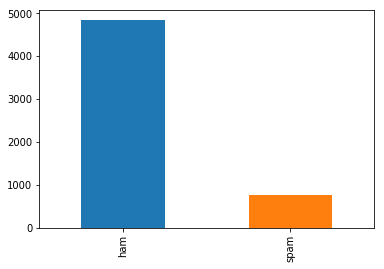

In [7]:
# check distribution of target variable (i.e. label in this case)

print(data['label'].value_counts())

data['label'].value_counts().plot.bar()

#### Plot histogram to check the lengths of Spam and Ham messages

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ACBA085FD0>,
      dtype=object)

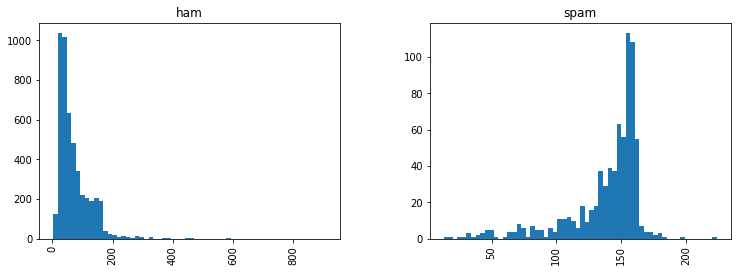

In [8]:
data.hist(column='length',by='label',bins=60,figsize=(12,4))

Here we can see that Spam messages are generally longer than Ham. Most of the Ham messages are about a 100 words. Whereas most spam messages are in 100-200 words (peaks around the 150+ range) 

#### Wordcloud of most frequently occuring words in Spam and Ham Messages

In [9]:
from wordcloud import WordCloud

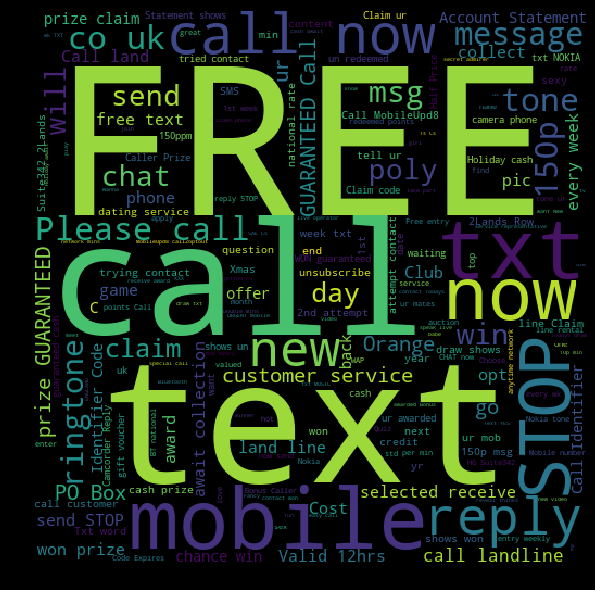

In [14]:
# Wordcloud for spam messages

spam_words = ''.join(list(data[data['spam']==1]['text']))
spam_wc = WordCloud(width= 512, height = 512).generate(spam_words)
plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

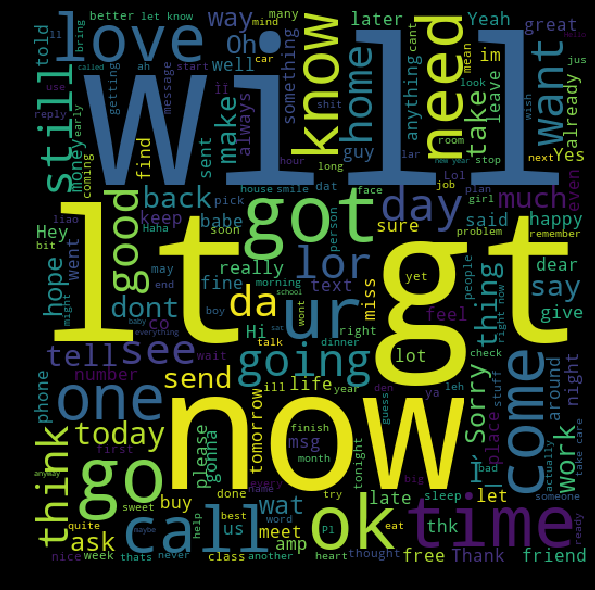

In [51]:
# Wordcloud for Ham messages

spam_words = ''.join(list(data[data['spam']==0]['text']))
spam_wc = WordCloud(width= 512, height = 512).generate(spam_words)
plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

##### Most commonly occuring word in spam mesages is FREE!!!! LOL :)

## Part 2 - Pre-processing 

#### Remove punctuations and stop words

In [15]:
# We use the punctuation list from the string library
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
# We use the stopwords list from nltk library

from nltk.corpus import stopwords
eng_SW = stopwords.words("english")
print(stopwords.words("english")[100:110])
print("Number of stop words: ",len(stopwords.words('english')))

['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']
Number of stop words:  179


In [17]:
def remove_punctuation_and_stopwords(message):
    
    # remove punctuation characters using list comprehension
    msg_no_punctuation = [char for char in message if char not in string.punctuation]
    msg_no_punctuation = "".join(msg_no_punctuation).split() # join each word and then split at spaces
    
    # remove stopwords and create new list of words
    msg_no_punctuation_no_stopwords = [word.lower() for word in msg_no_punctuation if word.lower() not in eng_SW]
    return msg_no_punctuation_no_stopwords

In [18]:
# TEST THE FUNCTION
# apply this function to the 'text' column of data frame
data['text'].apply(remove_punctuation_and_stopwords).head(10)
# can also be called using: remove_punctuation_and_stopwords(data['text'])

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
5    [freemsg, hey, darling, 3, weeks, word, back, ...
6    [even, brother, like, speak, treat, like, aids...
7    [per, request, melle, melle, oru, minnaminungi...
8    [winner, valued, network, customer, selected, ...
9    [mobile, 11, months, u, r, entitled, update, l...
Name: text, dtype: object

#### Apply bag of words model to the data

In [21]:
# fit bag of words model by removing punctuations and stop words (using remove_punctuation_and_stopwords function)
from sklearn.feature_extraction.text import CountVectorizer
bag_of_words_model_object = CountVectorizer(analyzer = remove_punctuation_and_stopwords).fit(data['text'])

##### Get dictionary of unique words and counts 

In [22]:
sample = bag_of_words_model_object.vocabulary_ # sample will be a dict of words as keys and the count as their values
print("There are",len(sample),"unique words after cleaning the messages in the bag of words")

There are 9431 unique words after cleaning the messages in the bag of words


In [23]:
print(sample)

{'go': 3748, 'jurong': 4644, 'point': 6376, 'crazy': 2463, 'available': 1375, 'bugis': 1840, 'n': 5624, 'great': 3845, 'world': 9107, 'la': 4803, 'e': 2988, 'buffet': 1838, 'cine': 2178, 'got': 3805, 'amore': 1142, 'wat': 8870, 'ok': 5940, 'lar': 4842, 'joking': 4612, 'wif': 9003, 'u': 8534, 'oni': 5972, 'free': 3539, 'entry': 3123, '2': 415, 'wkly': 9059, 'comp': 2294, 'win': 9017, 'fa': 3261, 'cup': 2518, 'final': 3385, 'tkts': 8311, '21st': 435, 'may': 5287, '2005': 422, 'text': 8150, '87121': 838, 'receive': 6774, 'questionstd': 6665, 'txt': 8518, 'ratetcs': 6718, 'apply': 1228, '08452810075over18s': 72, 'dun': 2974, 'say': 7129, 'early': 2995, 'hor': 4175, 'c': 1889, 'already': 1116, 'nah': 5631, 'dont': 2882, 'think': 8224, 'goes': 3762, 'usf': 8664, 'lives': 5004, 'around': 1279, 'though': 8243, 'freemsg': 3547, 'hey': 4071, 'darling': 2582, '3': 520, 'weeks': 8923, 'word': 9093, 'back': 1426, 'id': 4294, 'like': 4954, 'fun': 3610, 'still': 7793, 'tb': 8080, 'xxx': 9233, 'std': 

##### Creating feature vectors for sample spam message using bag of words

In [24]:
spam_temp = data['text'][8] # choose random spam row of data
print(spam_temp)
temp_spam_message_vector = bag_of_words_model_object.transform([spam_temp])
print(temp_spam_message_vector)

# transform converts the input into a document-term matrix

WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
  (0, 218)	1
  (0, 323)	1
  (0, 1906)	1
  (0, 2184)	2
  (0, 2245)	1
  (0, 2531)	1
  (0, 4194)	1
  (0, 4759)	1
  (0, 5707)	1
  (0, 6538)	1
  (0, 6775)	1
  (0, 6946)	1
  (0, 7209)	1
  (0, 8694)	1
  (0, 8698)	1
  (0, 9028)	1
  (0, 9418)	1


In [26]:
# length of the column vector will be the number of columns (shape[1])
temp_spam_message_vector.shape

(1, 9431)

In [33]:
# getting the non-zero columns from the vector (i.e. the words that are present in the message)
rows, cols = temp_spam_message_vector.nonzero()
    
list_of_features = [bag_of_words_model_object.get_feature_names()[col] for col in cols]

print(list_of_features)

['08002986030', '11', 'call', 'camera', 'co', 'colour', 'entitled', 'free', 'latest', 'mobile', 'mobiles', 'months', 'r', 'u', 'update']


These are the feature names of those columns that have non zero values in the feature vector for bag of words

In [34]:
spam_temp = data['text'][9] # choose another random spam row of data
print("The spam message is:")
print(spam_temp)
temp_spam_message_vector = bag_of_words_model_object.transform([spam_temp])
print(temp_spam_message_vector)

The spam message is:
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
  (0, 57)	1
  (0, 313)	1
  (0, 1906)	1
  (0, 1942)	1
  (0, 2234)	1
  (0, 2268)	1
  (0, 3120)	1
  (0, 3539)	2
  (0, 4859)	1
  (0, 5470)	2
  (0, 5471)	1
  (0, 5515)	1
  (0, 6679)	1
  (0, 8534)	1
  (0, 8621)	2


In [35]:
# length of the column vector will be the number of columns (shape[1])
temp_spam_message_vector.shape

(1, 9431)

In [36]:
# getting the non-zero columns from the vector (i.e. the words that are present in the message)
rows, cols = temp_spam_message_vector.nonzero()
list_of_features = [bag_of_words_model_object.get_feature_names()[col] for col in cols]

print(list_of_features)

['08002986030', '11', 'call', 'camera', 'co', 'colour', 'entitled', 'free', 'latest', 'mobile', 'mobiles', 'months', 'r', 'u', 'update']


These are the feature names of those columns that have non zero values in the feature vector for bag of words

In [37]:
temp_ham_msg = data['text'][4] # try it for a Ham message
print("The message is: ")
print(temp_ham_msg)
temp_ham_message_vector = bag_of_words_model_object.transform([temp_ham_msg])
print(temp_ham_message_vector)

The message is: 
Nah I don't think he goes to usf, he lives around here though
  (0, 1279)	1
  (0, 2882)	1
  (0, 3762)	1
  (0, 5004)	1
  (0, 5631)	1
  (0, 8224)	1
  (0, 8243)	1
  (0, 8664)	1


In [38]:
# getting the non-zero columns from the vector (i.e. the words that are present in the message)
rows, cols = temp_ham_message_vector.nonzero()

# getting the feature names from the indices of non zero columns
list_of_features = [bag_of_words_model_object.get_feature_names()[col] for col in cols]

print(list_of_features)

['around', 'dont', 'goes', 'lives', 'nah', 'think', 'though', 'usf']


These are the feature names in the sample Ham message that have non-zero counts.

### Create feature vectors for all the messages in the corpus

In [39]:
bow_feature_matrix = bag_of_words_model_object.transform(data['text'])

This feature matrix contains vectors for each message with the count of the words for each message. If the word is not present, it will contain a 0. Else it will contain the number of occurances of that word.

In [40]:
# checking the size and dimensions of the final feature matrix
print(bow_feature_matrix.shape)
print("Total number of elements in the feature matrix =",bow_feature_matrix.shape[0]*bow_feature_matrix.shape[1])
print("Total number of non-zero elements in the matrix =",bow_feature_matrix.nnz)

(5572, 9431)
Total number of elements in the feature matrix = 52549532
Total number of non-zero elements in the matrix = 49772


We can see that all 5572 messages have been converted into feature vectors with 9431 features each. Each feature vector will contain the total number of occurances of each word in the particular message. The entire feature matrix has 52549532 elements out of which only 49772 elements are non zero. This suggests that the matrix is sparse. This is because each message will only contain very few words out of the complete bag of words.

#### Calculate the Sparsity of the feature matrix

Sparsity is the fraction of non zero elements in the feature matrix

In [41]:
print((bow_feature_matrix.nnz/(bow_feature_matrix.shape[0]*bow_feature_matrix.shape[1]))*100)

0.09471444959776236


We can see that only 0.09% of the matrix is non zero.

### Calclate the TF-IDF scores for each word in the feature matrix

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer_object = TfidfTransformer().fit(bow_feature_matrix)

This will transform the sparse feature matrix (that contains the word counts for each word in a message into a tf-idf model object. We can fit any vector to this object to convert it into a vector of tf-idf scores instead of just the wordcounts

In [45]:
# Calculate the tf-idf scores for the above sample ham message vector using the tfidf model object
print("The sample Ham message is: ")
print(temp_ham_msg)
tfidf_sample_ham_vector = tfidf_transformer_object.transform(temp_ham_message_vector)
print(tfidf_sample_ham_vector)

The sample Ham message is: 
Nah I don't think he goes to usf, he lives around here though
  (0, 8664)	0.4000611457714059
  (0, 8243)	0.35462891367407595
  (0, 8224)	0.2665748147939407
  (0, 5631)	0.40493594386802356
  (0, 5004)	0.44910913790937335
  (0, 3762)	0.35674330934716636
  (0, 2882)	0.23016324066220836
  (0, 1279)	0.31179198007951625


In [46]:
tfidf_sample_ham_vector.shape

(1, 9431)

Again we can see that this is a column vector with 9431 features

In [48]:
print("The sample Spam message is: ")
print(spam_temp)
tfidf_sample_spam_vector = tfidf_transformer_object.transform(temp_spam_message_vector)
print(tfidf_sample_spam_vector)

The sample Spam message is: 
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
  (0, 8621)	0.4613515016782055
  (0, 8534)	0.10158633542920732
  (0, 6679)	0.16246850894146037
  (0, 5515)	0.24654148975832296
  (0, 5471)	0.24377794817235118
  (0, 5470)	0.33126679094840594
  (0, 4859)	0.20674426333259252
  (0, 3539)	0.2906791361988477
  (0, 3120)	0.25647395448704785
  (0, 2268)	0.22561414298808383
  (0, 2234)	0.26054051253610827
  (0, 1942)	0.2116151202102985
  (0, 1906)	0.1153699748612914
  (0, 313)	0.25283629435531674
  (0, 57)	0.29440446477134335


#### Calculate the tf-idf scores for all messages in the corpus

In [50]:
tfidf_feature_matrix = tfidf_transformer_object.transform(bow_feature_matrix)

In [51]:
tfidf_feature_matrix

<5572x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 49772 stored elements in Compressed Sparse Row format>

Here we can see that all 5572 messages have been converted to feature vectors with 9431 features for ech vector. Each of these vectors contains the tf-idf scores for each word in the message. This will again be a sparse matrix.

## Part 3 - Classification

### 3.1 Naive Bayes Classifier

In [52]:
# MultinomialNB - Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB

##### Make sample predictions on the entire dataset

In [53]:
# fit the model on the tfidf feature matrix and set the output vairable as the "spam" column
spam_detect_model = MultinomialNB().fit(tfidf_feature_matrix, data["spam"])

# make predictions on the same matrix
all_pred = spam_detect_model.predict(tfidf_feature_matrix)

all_pred[0:15]

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0])

In [54]:
# Response column 
print(data['spam'][0:15])

0     0
1     0
2     1
3     0
4     0
5     1
6     0
7     0
8     1
9     1
10    0
11    1
12    1
13    0
14    0
Name: spam, dtype: int32


Here we can see that most of the predictions are working correctly. But we are predicting using the same dataset we used to train the model. To assess the accuracy of the model, we need to split the dataset into training and testing, use the training set to train the model and then test it against the test dataset.

#### Split the dataset into Train and Test

In [55]:
from sklearn.model_selection import train_test_split


# randomly split the dataset into train and test with 67% of the data in the training set and 33% in the test set
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["spam"], test_size=0.33, random_state=5)

In [56]:
print("Size of training set =", len(X_train))
print("Size of test set =", len(X_test))

Size of training set = 3733
Size of test set = 1839


#### Next Steps:  
1. Use CountVectorizer to apply bag-of-words model to get all the words and counts in the corpus
2. Convert these counts into into document-text matirx with tf-idf scores for words in each message of the corpus
3. Apply multi-variate Naive Bayes model to the data

##### Pipeline can be used to accomplish this

In [57]:
''' Use Pipeline to sequentially apply an intermediate list of 
    transforms and fits to obtain a final estimator. The final estimator should
    only implement fit with the training data to train the model. 
'''

pipe_MNB = Pipeline([('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                     ('tfidf'   , TfidfTransformer()),
                     ('clf_MNB' , MultinomialNB()),
                    ])

In [58]:
# Fit the model to the training data
pipe_MNB.fit(X = X_train, y = y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x000001ACBA6FEAE8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range...r_tf=False, use_idf=True)), ('clf_MNB', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

##### Prediction

In [59]:
# Predict the values for the test data set
y_pred_MNB = pipe_MNB.predict(X_test)

# Calculate the accuracy of the classification
accuracy_ratio = accuracy_score(y_test,y_pred_MNB) # proportion of correct predictions
print("MNB predicted spam mails with an accuracy of",accuracy_ratio*100,"%")

MNB predicted spam mails with an accuracy of 96.46547036432844 %


#### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix for Naive Bayes Classifier')

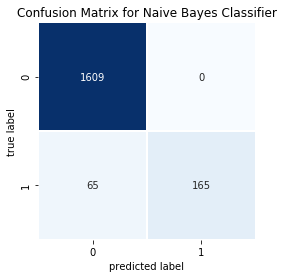

In [61]:
mtx = confusion_matrix(y_test, y_pred_MNB)

sns.heatmap(mtx,annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", square=True, cbar=False)
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.title('Confusion Matrix for Naive Bayes Classifier')

True Positives = 1609; True Negtives = 165;
False Positives = 0; False Negatives = 65

In [62]:
print("Sensitivity = ",mtx[0][0]/(mtx[0][0]+mtx[0][1]))
print("Specificity =",mtx[1][1]/(mtx[1][1]+mtx[1][0]))

Sensitivity =  1.0
Specificity = 0.717391304347826


### 3.2 KNN Classifier

#### Next Steps:  
1. Use CountVectorizer to apply bag-of-words model to get all the words and counts in the corpus
2. Convert these counts into into document-text matirx with tf-idf scores for words in each message of the corpus
3. Use KNN on this matrix to classify

##### Pipeline can be used to accomplish this

In [63]:
# k = 5 
pipe_KNN = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                   ('tfidf'   , TfidfTransformer()),
                   ('clf_KNN' , KNeighborsClassifier() ) 
                    ]) #default k=5
parameters_KNN = {'clf_KNN__n_neighbors': (1,), }

grid_KNN = GridSearchCV(pipe_KNN, parameters_KNN, cv=5,
                        n_jobs=-1, verbose=1)

In [64]:
# Use the training data set to train the model
grid_KNN.fit(X = X_train, y = y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x000001ACBA6FEAE8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clf_KNN__n_neighbors': (1,)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=1)

In [65]:
# Predict using the test data set
y_pred_KNN = grid_KNN.predict(X_test)

# Calculate the accuracy
acc_KNN = accuracy_score(y_test, y_pred_KNN)
print("KNN was able to predict Spam emails with and accuracy of ",acc_KNN*100,"%")

KNN was able to predict Spam emails with and accuracy of  96.08482871125612 %


#### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix for KNN Classifier')

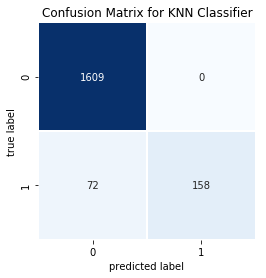

In [66]:
mtx = confusion_matrix(y_test, y_pred_KNN)

sns.heatmap(mtx,annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", square=True, cbar=False)
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.title('Confusion Matrix for KNN Classifier')

True Positives = 1609 ; True Negtives = 158;
False Positives = 0; False Negatives = 72

In [67]:
print("Sensitivity = ",mtx[0][0]/(mtx[0][0]+mtx[0][1]))
print("Specificity =",mtx[1][1]/(mtx[1][1]+mtx[1][0]))

Sensitivity =  1.0
Specificity = 0.6869565217391305


###### Since this model is used to classify spam emails, we need to make sure that the model correctly classifies the maximum number of Spam emails. The goal is to avoid recieving any spam email in our Inbox. We can afford to have some error of misclassifying a few ham emails as spam as we are interested in capturing all the Spam emails. So, the true negative rate (specificity) must be maximum.

##### Specificity for Multivariate Naive Bayes = 0.717
##### Specificity for K-NN (with k=1, this is the optimum value as seen below) = 0.686

Hence we are able to see that MNB is performing better at this than K-NN

In [276]:
# Checking Accuracy for multiple values of k
accuracy_list = []
true_positive_list = []
false_positive_list = []
true_negative_list = []
k_list = []
i=2
for i in range(1,20):
    print("k=",i)
    k_list.append(i)
    pipe_KNN = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                   ('tfidf'   , TfidfTransformer()),
                   ('clf_KNN' , KNeighborsClassifier() ) 
                    ])
    parameters_KNN = {'clf_KNN__n_neighbors': (i,), }
    grid_KNN = GridSearchCV(pipe_KNN, parameters_KNN, cv=5,
                        n_jobs=-1, verbose=1)
    grid_KNN.fit(X = X_train, y = y_train)
    y_pred_KNN = grid_KNN.predict(X_test)
    acc_KNN = accuracy_score(y_test, y_pred_KNN)
    accuracy_list.append(acc_KNN)
    mtx = confusion_matrix(y_test, y_pred_KNN)
    true_positive_list.append(mtx[0][0]/(mtx[0][0]+mtx[0][1]))
    false_positive_list.append(1-(mtx[1][1]/(mtx[1][1]+mtx[1][0])))
    true_negative_list.append(mtx[1][1]/(mtx[1][1]+mtx[1][0]))

k= 1
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.3s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


k= 2
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


k= 3
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


k= 4
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


k= 5
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


k= 6
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


k= 7
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


k= 8
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


k= 9
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


k= 10
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


k= 11
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


k= 12
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


k= 13
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


k= 14
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


k= 15
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


k= 16
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


k= 17
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


k= 18
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


k= 19
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


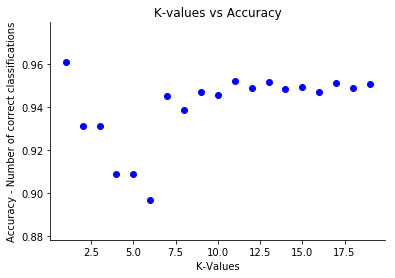

In [277]:
# Accuracy vs K-values

fig, ax = plt.subplots()
ax.scatter(k_list, accuracy_list, color="blue")
plt.xlabel('K-Values')
plt.ylabel('Accuracy - Number of correct classifications')
plt.title('K-values vs Accuracy')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

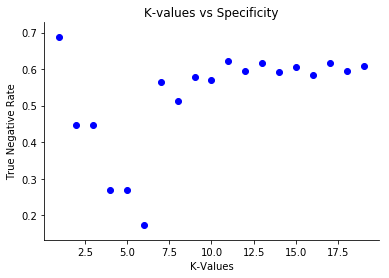

In [280]:
# True Negative vs K-values

fig, ax = plt.subplots()
ax.scatter(k_list, true_negative_list, color="blue")
plt.xlabel('K-Values')
plt.ylabel('True Negative Rate')
plt.title('K-values vs Specificity')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In the above graphs, we can see that we are getting maximum values of both Accuracy and Specificity (True Negative Rate) when k=1

### 3.3 Decision Tree

In [72]:
# applying decision tree classifier model with 5-fold cross validation

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# create a pipeline to perform sequential tranforms, specify DTree models for different depths using 5 fold cross-validation
pipe_DTree = Pipeline([('bow',CountVectorizer(analyzer = remove_punctuation_and_stopwords)),
                       ('tfidf',TfidfTransformer()),
                       ('DTree_model',DecisionTreeClassifier())])
parameters = {'DTree_model__criterion':['gini','entropy'],'DTree_model__max_depth':[5,10,15]}
DTree_model_tests = GridSearchCV(pipe_DTree, parameters, cv=5, verbose=1)

In [73]:
DTree_model_tests.fit(X = X_train, y = y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    7.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x000001ACBA6FEAE8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'DTree_model__criterion': ['gini', 'entropy'], 'DTree_model__max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [77]:
# Predict using the test data set
y_pred_DTree = DTree_model_tests.predict(X_test)

# Calculate the accuracy
acc_DTree = accuracy_score(y_test, y_pred_DTree)
print("Decision Tree was able to predict Spam emails with and accuracy of ",acc_DTree*100,"%")

Decision Tree was able to predict Spam emails with and accuracy of  95.26916802610114 %


#### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix for Decision Tree')

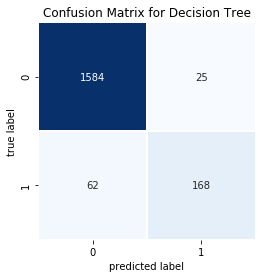

In [78]:
mtx = confusion_matrix(y_test, y_pred_DTree)

sns.heatmap(mtx,annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", square=True, cbar=False)
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.title('Confusion Matrix for Decision Tree')

True Positives = 1584 ; True Negtives = 168;
False Positives = 25; False Negatives = 62

In [79]:
print("Sensitivity = ",mtx[0][0]/(mtx[0][0]+mtx[0][1]))
print("Specificity =",mtx[1][1]/(mtx[1][1]+mtx[1][0]))

Sensitivity =  0.9844623990055935
Specificity = 0.7304347826086957


## Final Verdict


### Best to use Naive Bayes as it has the highet accuracy and specificity